In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode, read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import glob

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [4]:
dataset_path = "../../pics/2750/"
transform = ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)

In [5]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [7]:
#selected_classes = ['Forest', 'Industrial']
#selected_class_to_idx = {class_name: class_idx for class_name, class_idx in dataset.class_to_idx.items() if class_name in selected_classes}
forest_industrial_dataset = torch.utils.data.Subset(dataset, [1,4])

In [8]:
# Define the train-validation split ratio (e.g., 0.8 for 80% training, 0.2 for 20% validation)

train_ratio = 0.8
train_size = int(train_ratio * len(forest_industrial_dataset))
val_size = len(forest_industrial_dataset) - train_size


# Split the dataset into train and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [9]:
# Create dataloaders for train and validation sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [10]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(x.size(0), -1)
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  

In [11]:
import torch.optim as optim

In [12]:
# Initialize the CNN model
model = CNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs
num_epochs = 20

In [13]:
train_iter = iter(train_dataloader)
images, labels = next(train_iter)

In [14]:
epochs = 20
epochresults = []
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader: 
        #print(labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)

    epochresults.append(epoch_loss)
    print(f'Epochs:{epoch + 1:5d} | ' \
          f'Loss: {epoch_loss:.4f}')
    
    

Epochs:    1 | Loss: 0.6727
Epochs:    2 | Loss: 0.6720
Epochs:    3 | Loss: 0.6705
Epochs:    4 | Loss: 0.6685
Epochs:    5 | Loss: 0.6660
Epochs:    6 | Loss: 0.6629
Epochs:    7 | Loss: 0.6595
Epochs:    8 | Loss: 0.6557
Epochs:    9 | Loss: 0.6516
Epochs:   10 | Loss: 0.6472
Epochs:   11 | Loss: 0.6426
Epochs:   12 | Loss: 0.6380
Epochs:   13 | Loss: 0.6331
Epochs:   14 | Loss: 0.6281
Epochs:   15 | Loss: 0.6230
Epochs:   16 | Loss: 0.6179
Epochs:   17 | Loss: 0.6127
Epochs:   18 | Loss: 0.6074
Epochs:   19 | Loss: 0.6021
Epochs:   20 | Loss: 0.5967


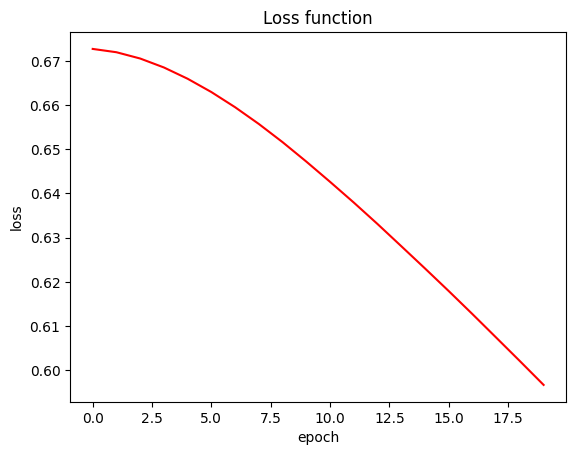

In [15]:
fig, ax = plt.subplots()
ax.set(xlabel='epoch', ylabel='loss', title="Loss function")

plt.plot(epochresults, 'red')
plt.show()

In [ ]:
# Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")